# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
st = time.time()
df = pd.read_csv('./new_feature_by_kageyama_feature_matrix.csv')
time.time() - st

132.4644193649292

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 39/39 [00:42<00:00,  1.10s/it]


36

In [4]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758522	valid_1's auc: 0.751612
[200]	training's auc: 0.780609	valid_1's auc: 0.7645
[300]	training's auc: 0.797979	valid_1's auc: 0.774016
[400]	training's auc: 0.809705	valid_1's auc: 0.778773
[500]	training's auc: 0.818848	valid_1's auc: 0.781473
[600]	training's auc: 0.826918	valid_1's auc: 0.783307
[700]	training's auc: 0.834085	valid_1's auc: 0.7845
[800]	training's auc: 0.840388	valid_1's auc: 0.785268
[900]	training's auc: 0.84643	valid_1's auc: 0.785941
[1000]	training's auc: 0.851855	valid_1's auc: 0.786313
[1100]	training's auc: 0.857089	valid_1's auc: 0.786893
[1200]	training's auc: 0.861968	valid_1's auc: 0.786903
[1300]	training's auc: 0.866778	valid_1's auc: 0.78724
[1400]	training's auc: 0.871161	valid_1's auc: 0.787675
[1500]	training's auc: 0.875391	valid_1's auc: 0.787865
[1600]	training's auc: 0.879609	valid_1's auc: 0.787961
[1700]	training's auc: 0.883412	valid_1's auc: 0.788314


[600]	training's auc: 0.826973	valid_1's auc: 0.782228
[700]	training's auc: 0.834225	valid_1's auc: 0.783968
[800]	training's auc: 0.840493	valid_1's auc: 0.784852
[900]	training's auc: 0.846332	valid_1's auc: 0.785433
[1000]	training's auc: 0.851729	valid_1's auc: 0.785879
[1100]	training's auc: 0.856932	valid_1's auc: 0.786614
[1200]	training's auc: 0.861821	valid_1's auc: 0.78713
[1300]	training's auc: 0.866504	valid_1's auc: 0.787266
[1400]	training's auc: 0.87075	valid_1's auc: 0.787358
[1500]	training's auc: 0.874919	valid_1's auc: 0.78757
[1600]	training's auc: 0.879076	valid_1's auc: 0.787668
[1700]	training's auc: 0.883215	valid_1's auc: 0.787588
Early stopping, best iteration is:
[1625]	training's auc: 0.880164	valid_1's auc: 0.787888
Fold  8 AUC : 0.787888
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758788	valid_1's auc: 0.746532
[200]	training's auc: 0.781	valid_1's auc: 0.75937
[300]	training's auc: 0.798315	valid_1's auc: 0.7692

[900]	training's auc: 0.846366	valid_1's auc: 0.787196
[1000]	training's auc: 0.851669	valid_1's auc: 0.788045
[1100]	training's auc: 0.856874	valid_1's auc: 0.788389
[1200]	training's auc: 0.861571	valid_1's auc: 0.788965
[1300]	training's auc: 0.866324	valid_1's auc: 0.789025
[1400]	training's auc: 0.870883	valid_1's auc: 0.789223
Early stopping, best iteration is:
[1341]	training's auc: 0.868253	valid_1's auc: 0.789234
Fold 15 AUC : 0.789234
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758381	valid_1's auc: 0.749318
[200]	training's auc: 0.780264	valid_1's auc: 0.765689
[300]	training's auc: 0.797661	valid_1's auc: 0.77808
[400]	training's auc: 0.809407	valid_1's auc: 0.784314
[500]	training's auc: 0.818762	valid_1's auc: 0.788063
[600]	training's auc: 0.826672	valid_1's auc: 0.790367
[700]	training's auc: 0.833858	valid_1's auc: 0.791605
[800]	training's auc: 0.840374	valid_1's auc: 0.792292
[900]	training's auc: 0.846399	valid_1's auc: 0.7

[1200]	training's auc: 0.861883	valid_1's auc: 0.790802
[1300]	training's auc: 0.866649	valid_1's auc: 0.79107
[1400]	training's auc: 0.870987	valid_1's auc: 0.791048
[1500]	training's auc: 0.875074	valid_1's auc: 0.791265
[1600]	training's auc: 0.879174	valid_1's auc: 0.791381
[1700]	training's auc: 0.883428	valid_1's auc: 0.791856
Early stopping, best iteration is:
[1697]	training's auc: 0.88329	valid_1's auc: 0.791894
Fold 24 AUC : 0.791894
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758699	valid_1's auc: 0.746505
[200]	training's auc: 0.780358	valid_1's auc: 0.765733
[300]	training's auc: 0.797504	valid_1's auc: 0.77832
[400]	training's auc: 0.809081	valid_1's auc: 0.785333
[500]	training's auc: 0.818506	valid_1's auc: 0.789209
[600]	training's auc: 0.826421	valid_1's auc: 0.791465
[700]	training's auc: 0.833619	valid_1's auc: 0.79289
[800]	training's auc: 0.84015	valid_1's auc: 0.794055
[900]	training's auc: 0.846173	valid_1's auc: 0.7947

In [5]:
sub.to_csv('./kageyama_feature_matrix_25cv_tuned_by_Ivan_sub.csv', index=None)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


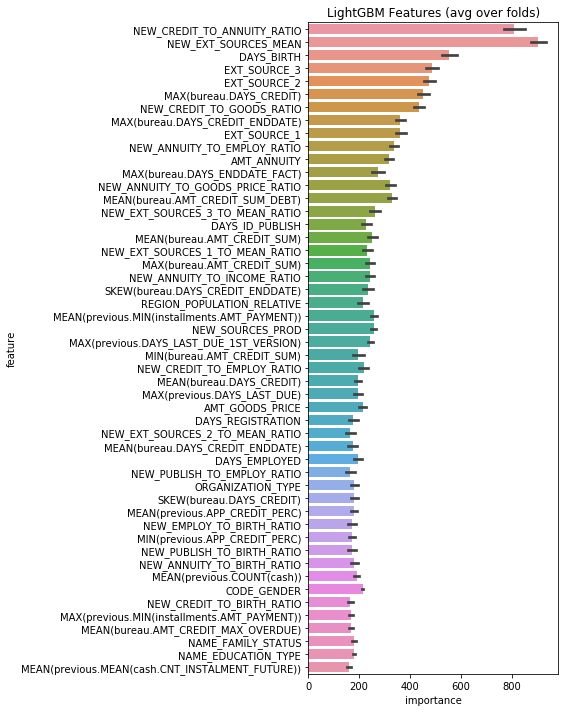

In [7]:
display_importances(feature_importance_df)

In [8]:
time.time() - st

22908.227449655533